<span style="color: purple">

Load in stored variables:

</span>

In [2]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf

<span style="color: purple">

Import packages:

</span>

In [3]:
# Import necessary packages
import os

import holoviews as hv
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import pandas as pd # Aggregating and data manipulation
from tqdm.notebook import tqdm # Progress bars on loops
import xarray as xr

## STEP 2c: DATA ACCESS - CLIMATE MODELS

You can use MACAv2 data for historical and future climate data. Be sure
to compare at least two 30-year time periods (e.g. historical vs. 10
years in the future) for at least four of the CMIP models. Overall, you
should be downloading at least 8 climate rasters for each of your sites,
for a total of 16. **You will *need* to use loops and/or functions to do
this cleanly!**.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download MACAv2 data for a particular climate model, emissions
scenario, spatial domain, and time frame. Then, use loops to download
and organize the 16+ rasters you will need to complete this section. The
<a
href="http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html">MACAv2
dataset is accessible from their Thredds server</a>. Include an
arrangement of sites, models, emissions scenarios, and time periods that
will help you to answer your scientific question.</p></div></div>

<span style="color: purple">

List of climate models:

</span>

<span style="color: magenta">

* Warm and wet: CanESM2

</span>

<span style="color: limegreen">

* Warm and dry: MIROC-ESM-CHEM

</span>

<span style="color: teal">

* Cold and wet: MRI-CGCM3

</span>

<span style="color: black">

* Cold and dry: GFDL-ESM2M

</span>

<span style="color: purple">

<span style="color: purple">

The time periods I will compare are:

* 2036 to 2065 - this will allow for a summary of climate for 2050
* 2066 to 2095 - this will allow for a summary of climate for 2080

Climate variable I will focus on: the average annual precipitation.
</span>

In [4]:
# Make MACA data directory
maca_dir = os.path.join(data_dir, 'maca-dir')
os.makedirs(maca_dir, exist_ok=True)
maca_dir

maca_pattern = os.path.join(maca_dir, '*.nc')
maca_pattern

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\maca-dir\\*.nc'

<span style="color: purple">

Define functions:

</span>

In [5]:
# Define function to convert longitude/latitude
def convert_longitude(longitude):
    """
    Convert longitude range from 0-360 to -180-180
    
    Parameters
    ----------
    longitude : float
        `longitude` values of dataset
    
    Returns
    -------
    longitude : float
        Longitude values converted from 0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

In [6]:
def process_maca_da(site_dict,
                    years_list,
                    models_list,
                    rcp_value,
                    maca_data_dir):
    """
    Create a URL to access MACA climate precipitation data from the Northwest Knowledge Network.
    Use the URL to download, open, squeeze, and crop raster climate precipitation data.
    
    Parameters
    ----------
    site_dict : dict
        Dictionary of site GeoDataFrames
    years_list : list
        List of 5 year time periods
    models_list : list
        List of climate model names
    rcp_value : str
        Representative Concentration Pathway value
    maca_data_dir: str
        file path where maca NetCDF files will be stored

    Returns
    -------
    maca_da_list : list
        A list of dictionaries of DataArrays of climate data (precipitation) for
        the different rasters covering the area of interest
    """
    # empty list to store processed MACA DataArrays
    maca_da_list = []

    for site_name, site_gdf in tqdm(site_dict.items()):
        for date_range in tqdm(years_list):
            for model in tqdm(models_list):
                # Define MACA url
                maca_url = (
                    'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
                    '/MACAV2'
                    f'/{model}'
                    '/macav2metdata_pr'
                    f'_{model}_r1i1p1'
                    f'_{rcp_value}'
                    f'_{date_range}_CONUS'
                    '_monthly.nc')
                # check maca_url
                print(maca_url)

                # Only download MACA data once
                maca_path = os.path.join(maca_data_dir, f'maca_{model}_{site_name}_{rcp_value}_{date_range}_CONUS_monthly.nc')
                print(maca_path)
                if not os.path.exists(maca_path):
                    maca_da = xr.open_dataset(maca_url).squeeze().precipitation
                    maca_da.to_netcdf(maca_path)

                # Open & Squeeze MACA dataset
                maca_da = xr.open_dataset(maca_url).squeeze().precipitation
                print('Opened & Squeezed')

                # Define bounds
                bounds_maca = (site_gdf
                                .to_crs(maca_da.rio.crs)
                                .total_bounds)

                # Change maca_ds longitude values to match the foest gdfs
                maca_da = maca_da.assign_coords(
                    lon=("lon", [convert_longitude(l) for l in maca_da.lon.values]))

                # Set spatial dimensions of maca_da
                maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

                # Crop maca_da
                maca_da = maca_da.rio.clip_box(*bounds_maca)
                print('Cropped')

                # Add cropped da to a dictionary w/ metadata and then the maca_da_list
                maca_da_list.append(dict(
                    site_name=site_name,
                    climate_model=model,
                    date_range=date_range,
                    da=maca_da))
    return maca_da_list

<span style="color: purple">

Set up variables to use in process_maca_da function:

</span>

In [7]:
# site dictionary
siskiyou_padres_dict = {
    'SiskiyouForest': siskiyou_forest_gdf,
    'LosPadresForest': padres_forest_gdf
}

# list of time periods to create MACA urls
years_2050 = ['2036_2040', '2041_2045', '2046_2050',
         '2051_2055', '2056_2060', '2061_2065']

years_2080 = ['2066_2070', '2071_2075', '2076_2080',
              '2081_2085', '2086_2090', '2091_2095']

# list of climate models
climate_models = ['CanESM2', 'MIROC-ESM-CHEM',
          'MRI-CGCM3', 'GFDL-ESM2M']

<span style="color: purple">

Process MACA DataArrays for 2050 time period for both sites for all 4 climate models:

</span>

In [8]:
# load in and process the MACA data for the 2050 time period (2036-2065)
# for both national forests
# for all four climate models
maca_pr_2050_da_list = process_maca_da(siskiyou_padres_dict,
                                       years_2050,
                                       climate_models,
                                       'rcp85',
                                       maca_dir)

# check result
maca_pr_2050_da_list

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

[{'site_name': 'SiskiyouForest',
  'climate_model': 'CanESM2',
  'date_range': '2036_2040',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 values with dtype=float32]
  Coordinates:
    * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
    * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
    * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
      crs      int64 8B 0
  Attributes:
      long_name:      Monthly Precipitation Amount
      units:          mm
      standard_name:  precipitation
      cell_methods:   time: sum(interval: 24 hours): sum over days
      comments:       Total monthly precipitation at surface: includes both liq...
      _ChunkSizes:    [ 10  44 107]},
 {'site_name': 'SiskiyouForest',
  'climate_model': 'MIROC-ESM-CHEM',
  'date_range': '2036_2040',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 value

In [9]:
# Convert the maca_pr_2050_da_list into a DataFrame
maca_pr_2050_df = pd.DataFrame(maca_pr_2050_da_list)

# Display maca_df w/o DataArray column
display(maca_pr_2050_df.drop('da', axis='columns'))

# Pull out the data array for the first row
maca_pr_2050_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2036_2040
1,SiskiyouForest,MIROC-ESM-CHEM,2036_2040
2,SiskiyouForest,MRI-CGCM3,2036_2040
3,SiskiyouForest,GFDL-ESM2M,2036_2040
4,SiskiyouForest,CanESM2,2041_2045
5,SiskiyouForest,MIROC-ESM-CHEM,2041_2045
6,SiskiyouForest,MRI-CGCM3,2041_2045
7,SiskiyouForest,GFDL-ESM2M,2041_2045
8,SiskiyouForest,CanESM2,2046_2050
9,SiskiyouForest,MIROC-ESM-CHEM,2046_2050


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<span style="color: purple">

Process MACA DataArrays for 2080 time period for both sites for all 4 climate models:

</span>

In [10]:
# load in and process the MACA data for the 2080 time period (2066-2095)
# for both national forests
# for all four climate models
maca_pr_2080_da_list = process_maca_da(siskiyou_padres_dict,
                                       years_2080,
                                       climate_models,
                                       'rcp85',
                                       maca_dir)

# check result
maca_pr_2080_da_list

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

[{'site_name': 'SiskiyouForest',
  'climate_model': 'CanESM2',
  'date_range': '2066_2070',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 values with dtype=float32]
  Coordinates:
    * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
    * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
    * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
      crs      int64 8B 0
  Attributes:
      long_name:      Monthly Precipitation Amount
      units:          mm
      standard_name:  precipitation
      cell_methods:   time: sum(interval: 24 hours): sum over days
      comments:       Total monthly precipitation at surface: includes both liq...
      _ChunkSizes:    [ 10  44 107]},
 {'site_name': 'SiskiyouForest',
  'climate_model': 'MIROC-ESM-CHEM',
  'date_range': '2066_2070',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 value

In [11]:
# Convert the maca_pr_2050_da_list into a DataFrame
maca_pr_2080_df = pd.DataFrame(maca_pr_2080_da_list)

# Display maca_df w/o DataArray column
display(maca_pr_2080_df.drop('da', axis='columns'))

# Pull out the data array for the first row
maca_pr_2080_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2066_2070
1,SiskiyouForest,MIROC-ESM-CHEM,2066_2070
2,SiskiyouForest,MRI-CGCM3,2066_2070
3,SiskiyouForest,GFDL-ESM2M,2066_2070
4,SiskiyouForest,CanESM2,2071_2075
5,SiskiyouForest,MIROC-ESM-CHEM,2071_2075
6,SiskiyouForest,MRI-CGCM3,2071_2075
7,SiskiyouForest,GFDL-ESM2M,2071_2075
8,SiskiyouForest,CanESM2,2076_2080
9,SiskiyouForest,MIROC-ESM-CHEM,2076_2080


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<span style="color: purple">

Split each DataFrame for each time period up by model and site. Instead of having two DataFrames for each time period, I will now have 16 DataFrames. Each DataFrame will be for a specific site/climate model/time period combination. For example, there will be a DataFrame for Siskiyou/CanESM2/2036-2065. There will also be a DataFrame for Siskiyou/MIROC-ESM-CHEM/2036-2065. There will also be a DataFrame for Los Padres/CanESM2/2036-2065 and one for Los Padres/CanESM2/2066-2095.

So, each national forest will have 8 DataFrames. 8 for each time period (4 for Siskiyou, 4 for Los Padres). Each DataFrame will represent one of the 4 different climate models, one of the sites, and one of the time periods so that we can analyze the projected amount of precipitation in each time period for each model for each site. 

</span>

In [12]:
# select the Siskiyou rows from the maca_pr_2050_df
siskiyou_2050_df = maca_pr_2050_df[maca_pr_2050_df['site_name']=='SiskiyouForest']

# select the CanESM2 rows from the siskiyou_2050_df
siskiyou_2050_can_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the siskiyou_2050_df
siskiyou_2050_miroc_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the siskiyou_2050_df
siskiyou_2050_mri_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the siskiyou_2050_df
siskiyou_2050_gfdl_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(siskiyou_2050_can_df.drop('da', axis='columns'))
display(siskiyou_2050_miroc_df.drop('da', axis='columns'))
display(siskiyou_2050_mri_df.drop('da', axis='columns'))
display(siskiyou_2050_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
siskiyou_2050_can_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2036_2040
4,SiskiyouForest,CanESM2,2041_2045
8,SiskiyouForest,CanESM2,2046_2050
12,SiskiyouForest,CanESM2,2051_2055
16,SiskiyouForest,CanESM2,2056_2060
20,SiskiyouForest,CanESM2,2061_2065


,site_name,climate_model,date_range
1,SiskiyouForest,MIROC-ESM-CHEM,2036_2040
5,SiskiyouForest,MIROC-ESM-CHEM,2041_2045
9,SiskiyouForest,MIROC-ESM-CHEM,2046_2050
13,SiskiyouForest,MIROC-ESM-CHEM,2051_2055
17,SiskiyouForest,MIROC-ESM-CHEM,2056_2060
21,SiskiyouForest,MIROC-ESM-CHEM,2061_2065


,site_name,climate_model,date_range
2,SiskiyouForest,MRI-CGCM3,2036_2040
6,SiskiyouForest,MRI-CGCM3,2041_2045
10,SiskiyouForest,MRI-CGCM3,2046_2050
14,SiskiyouForest,MRI-CGCM3,2051_2055
18,SiskiyouForest,MRI-CGCM3,2056_2060
22,SiskiyouForest,MRI-CGCM3,2061_2065


,site_name,climate_model,date_range
3,SiskiyouForest,GFDL-ESM2M,2036_2040
7,SiskiyouForest,GFDL-ESM2M,2041_2045
11,SiskiyouForest,GFDL-ESM2M,2046_2050
15,SiskiyouForest,GFDL-ESM2M,2051_2055
19,SiskiyouForest,GFDL-ESM2M,2056_2060
23,SiskiyouForest,GFDL-ESM2M,2061_2065


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [13]:
# select the Siskiyou rows from the maca_pr_2080_df
siskyou_2080_df = maca_pr_2080_df[maca_pr_2080_df['site_name']=='SiskiyouForest']

# select the CanESM2 rows from the siskyou_2080_df
siskiyou_2080_can_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the siskyou_2080_df
siskiyou_2080_miroc_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the siskyou_2080_df
siskiyou_2080_mri_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the siskyou_2080_df
siskiyou_2080_gfdl_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(siskiyou_2080_can_df.drop('da', axis='columns'))
display(siskiyou_2080_miroc_df.drop('da', axis='columns'))
display(siskiyou_2080_mri_df.drop('da', axis='columns'))
display(siskiyou_2080_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
siskiyou_2080_can_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2066_2070
4,SiskiyouForest,CanESM2,2071_2075
8,SiskiyouForest,CanESM2,2076_2080
12,SiskiyouForest,CanESM2,2081_2085
16,SiskiyouForest,CanESM2,2086_2090
20,SiskiyouForest,CanESM2,2091_2095


,site_name,climate_model,date_range
1,SiskiyouForest,MIROC-ESM-CHEM,2066_2070
5,SiskiyouForest,MIROC-ESM-CHEM,2071_2075
9,SiskiyouForest,MIROC-ESM-CHEM,2076_2080
13,SiskiyouForest,MIROC-ESM-CHEM,2081_2085
17,SiskiyouForest,MIROC-ESM-CHEM,2086_2090
21,SiskiyouForest,MIROC-ESM-CHEM,2091_2095


,site_name,climate_model,date_range
2,SiskiyouForest,MRI-CGCM3,2066_2070
6,SiskiyouForest,MRI-CGCM3,2071_2075
10,SiskiyouForest,MRI-CGCM3,2076_2080
14,SiskiyouForest,MRI-CGCM3,2081_2085
18,SiskiyouForest,MRI-CGCM3,2086_2090
22,SiskiyouForest,MRI-CGCM3,2091_2095


,site_name,climate_model,date_range
3,SiskiyouForest,GFDL-ESM2M,2066_2070
7,SiskiyouForest,GFDL-ESM2M,2071_2075
11,SiskiyouForest,GFDL-ESM2M,2076_2080
15,SiskiyouForest,GFDL-ESM2M,2081_2085
19,SiskiyouForest,GFDL-ESM2M,2086_2090
23,SiskiyouForest,GFDL-ESM2M,2091_2095


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [14]:
# select the Los Padres rows from the maca_pr_2050_df
padres_2050_df = maca_pr_2050_df[maca_pr_2050_df['site_name']=='LosPadresForest']

# select the CanESM2 rows from the padres_2050_df
padres_2050_can_df = padres_2050_df[padres_2050_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the padres_2050_df
padres_2050_miroc_df = padres_2050_df[padres_2050_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the padres_2050_df
padres_2050_mri_df = padres_2050_df[padres_2050_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the padres_2050_df
padres_2050_gfdl_df = padres_2050_df[padres_2050_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(padres_2050_can_df.drop('da', axis='columns'))
display(padres_2050_miroc_df.drop('da', axis='columns'))
display(padres_2050_mri_df.drop('da', axis='columns'))
display(padres_2050_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
padres_2050_can_df.da.values[0]

,site_name,climate_model,date_range
24,LosPadresForest,CanESM2,2036_2040
28,LosPadresForest,CanESM2,2041_2045
32,LosPadresForest,CanESM2,2046_2050
36,LosPadresForest,CanESM2,2051_2055
40,LosPadresForest,CanESM2,2056_2060
44,LosPadresForest,CanESM2,2061_2065


,site_name,climate_model,date_range
25,LosPadresForest,MIROC-ESM-CHEM,2036_2040
29,LosPadresForest,MIROC-ESM-CHEM,2041_2045
33,LosPadresForest,MIROC-ESM-CHEM,2046_2050
37,LosPadresForest,MIROC-ESM-CHEM,2051_2055
41,LosPadresForest,MIROC-ESM-CHEM,2056_2060
45,LosPadresForest,MIROC-ESM-CHEM,2061_2065


,site_name,climate_model,date_range
26,LosPadresForest,MRI-CGCM3,2036_2040
30,LosPadresForest,MRI-CGCM3,2041_2045
34,LosPadresForest,MRI-CGCM3,2046_2050
38,LosPadresForest,MRI-CGCM3,2051_2055
42,LosPadresForest,MRI-CGCM3,2056_2060
46,LosPadresForest,MRI-CGCM3,2061_2065


,site_name,climate_model,date_range
27,LosPadresForest,GFDL-ESM2M,2036_2040
31,LosPadresForest,GFDL-ESM2M,2041_2045
35,LosPadresForest,GFDL-ESM2M,2046_2050
39,LosPadresForest,GFDL-ESM2M,2051_2055
43,LosPadresForest,GFDL-ESM2M,2056_2060
47,LosPadresForest,GFDL-ESM2M,2061_2065


<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [15]:
# select the Los Padres rows from the maca_pr_2080_df
padres_2080_df = maca_pr_2080_df[maca_pr_2080_df['site_name']=='LosPadresForest']

# select the CanESM2 rows from the padres_2080_df
padres_2080_can_df = padres_2080_df[padres_2080_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the padres_2080_df
padres_2080_miroc_df = padres_2080_df[padres_2080_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the padres_2080_df
padres_2080_mri_df = padres_2080_df[padres_2080_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the padres_2080_df
padres_2080_gfdl_df = padres_2080_df[padres_2080_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(padres_2080_can_df.drop('da', axis='columns'))
display(padres_2080_miroc_df.drop('da', axis='columns'))
display(padres_2080_mri_df.drop('da', axis='columns'))
display(padres_2080_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
padres_2080_can_df.da.values[0]

,site_name,climate_model,date_range
24,LosPadresForest,CanESM2,2066_2070
28,LosPadresForest,CanESM2,2071_2075
32,LosPadresForest,CanESM2,2076_2080
36,LosPadresForest,CanESM2,2081_2085
40,LosPadresForest,CanESM2,2086_2090
44,LosPadresForest,CanESM2,2091_2095


,site_name,climate_model,date_range
25,LosPadresForest,MIROC-ESM-CHEM,2066_2070
29,LosPadresForest,MIROC-ESM-CHEM,2071_2075
33,LosPadresForest,MIROC-ESM-CHEM,2076_2080
37,LosPadresForest,MIROC-ESM-CHEM,2081_2085
41,LosPadresForest,MIROC-ESM-CHEM,2086_2090
45,LosPadresForest,MIROC-ESM-CHEM,2091_2095


,site_name,climate_model,date_range
26,LosPadresForest,MRI-CGCM3,2066_2070
30,LosPadresForest,MRI-CGCM3,2071_2075
34,LosPadresForest,MRI-CGCM3,2076_2080
38,LosPadresForest,MRI-CGCM3,2081_2085
42,LosPadresForest,MRI-CGCM3,2086_2090
46,LosPadresForest,MRI-CGCM3,2091_2095


,site_name,climate_model,date_range
27,LosPadresForest,GFDL-ESM2M,2066_2070
31,LosPadresForest,GFDL-ESM2M,2071_2075
35,LosPadresForest,GFDL-ESM2M,2076_2080
39,LosPadresForest,GFDL-ESM2M,2081_2085
43,LosPadresForest,GFDL-ESM2M,2086_2090
47,LosPadresForest,GFDL-ESM2M,2091_2095


<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<span style="color:purple">

I want to know:

* For each site,
* for each 30-year time period,
* for each climate model,

what is the predicted average annual precipitation?

So for example, what is the predicted average annual precipitation for 2050 (the 2036-2065 time period) for Siskiyou according to the CanESM2 model?

What is the predicted average annual precipitation for 2050 (the 2036-2065 time period) for Siskiyou according to the MIROC-ESM-CHEM model?

What is the predicated average annual precipitation for 2050 (the 2036-2065 time period) for Los Padres according to the CanESM2 model?

What is the predicted average annual precipitation for 2050 (the 2036-2065 time period) for Los Padres according to the MIROC-ESM-CHEM model?

etc...

### Define a function to find the predicted average annual precipitation over each 30 year time period represented by each subsetted DataFrame.

</span>

In [16]:
def ave_annual_pr(df_len, df):
    """
    Calculate the predicted average annual precipitation
    for the DataArrays in a DataFrame.

    Parameters
    ----------
    df_len : int
        the number of rows in the DataFrame
    df : DataFrame
        the DataFrame that houses the DataArrays

    Returns
    -------
    df_ave_annual_precip_da: DataArray
        A DataArray with the predicted average annual precipitation
        over the total time period of the DataFrame
    """

    # empty list to store the average annual precipitation
    # for the DataArray in each row of a DataFrame
    row_ave_annual_precip_das = []

    # for each of the rows in the DataFrame,
    for num in tqdm(range(df_len)):
        #access the DataArray in that row
        row_da = df.da.values[num]

        # add a CRS and set the spatial dimensions of the row_da
        crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

        # calculate the total precip for each individual year
        # in the time period of the crs_spatial_da
        annual_precip_da = crs_spatial_da.groupby('time.year').sum()

        # calculate the average annual precip for 
        # the total time period of the row_da
        ave_annual_precip_da = annual_precip_da.mean(['year'])

        # add ave_annual_precip_da to row_ave_annual_precip_das list
        row_ave_annual_precip_das.append(ave_annual_precip_da)

    # calculate the average annual precip for the
    # total time period of the whole DataFrame
    df_ave_annual_precip_da = (
        xr.concat(row_ave_annual_precip_das, dim='stack')
        .mean(dim='stack'))
    
    return df_ave_annual_precip_da

In [17]:
# Use a for loop to test the function defined above on a list of the Siskiyou 2050 DataFrames
siskiyou_2050_df_list = [
    siskiyou_2050_can_df,
    siskiyou_2050_miroc_df,
    siskiyou_2050_mri_df,
    siskiyou_2050_gfdl_df
    ]

# empty list to accumulate the 30 year average annual precip for each df
siskiyou_2050_30_yr_averages = []

# for each of the dfs in the list,
for i in siskiyou_2050_df_list:

    # use the ave_annual_pr function to find the 30 year average annual precip
    thirty_yr_average = ave_annual_pr(6, i)
    
    # add the 30 year average annual precip to the empty list
    siskiyou_2050_30_yr_averages.append(thirty_yr_average)

# check the result
siskiyou_2050_30_yr_averages

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
         2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
         3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
         2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
         2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
         2001.5524 , 1964.2653 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
         2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
         3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
         2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
         2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
         1814.4025 , 1866.5381 ],
        [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
         2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
         3139.0918 , 3216.8691 , 3160.7

In [18]:
# create a list of all the subsetted DataFrames
climate_df_list = [
    siskiyou_2050_can_df,
    siskiyou_2050_miroc_df,
    siskiyou_2050_mri_df,
    siskiyou_2050_gfdl_df,
    siskiyou_2080_can_df,
    siskiyou_2080_miroc_df,
    siskiyou_2080_mri_df,
    siskiyou_2080_gfdl_df,
    padres_2050_can_df,
    padres_2050_miroc_df,
    padres_2050_mri_df,
    padres_2050_gfdl_df,
    padres_2080_can_df,
    padres_2080_miroc_df,
    padres_2080_mri_df,
    padres_2080_gfdl_df
]

# Use a for loop and the ave_annual_pr fxn to find the 30-year average annual precipitation for each subsetted DataFrame

# empty list to accumulate the 30 year average annual precip for each df
ave_annual_pr_das_list = []

# for each of the dfs in the list,
for i in climate_df_list:

    # use the ave_annual_pr function to find the 30 year average annual precip
    thirty_yr_average = ave_annual_pr(6, i)

    # add the 30 year average annual precip to the empty list
    ave_annual_pr_das_list.append(thirty_yr_average)

# check the result
# the first four DataArrays in this list should match
# the siskiyou_2050_30_yr_averages list
ave_annual_pr_das_list

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
         2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
         3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
         2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
         2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
         2001.5524 , 1964.2653 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
         2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
         3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
         2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
         2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
         1814.4025 , 1866.5381 ],
        [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
         2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
         3139.0918 , 3216.8691 , 3160.7

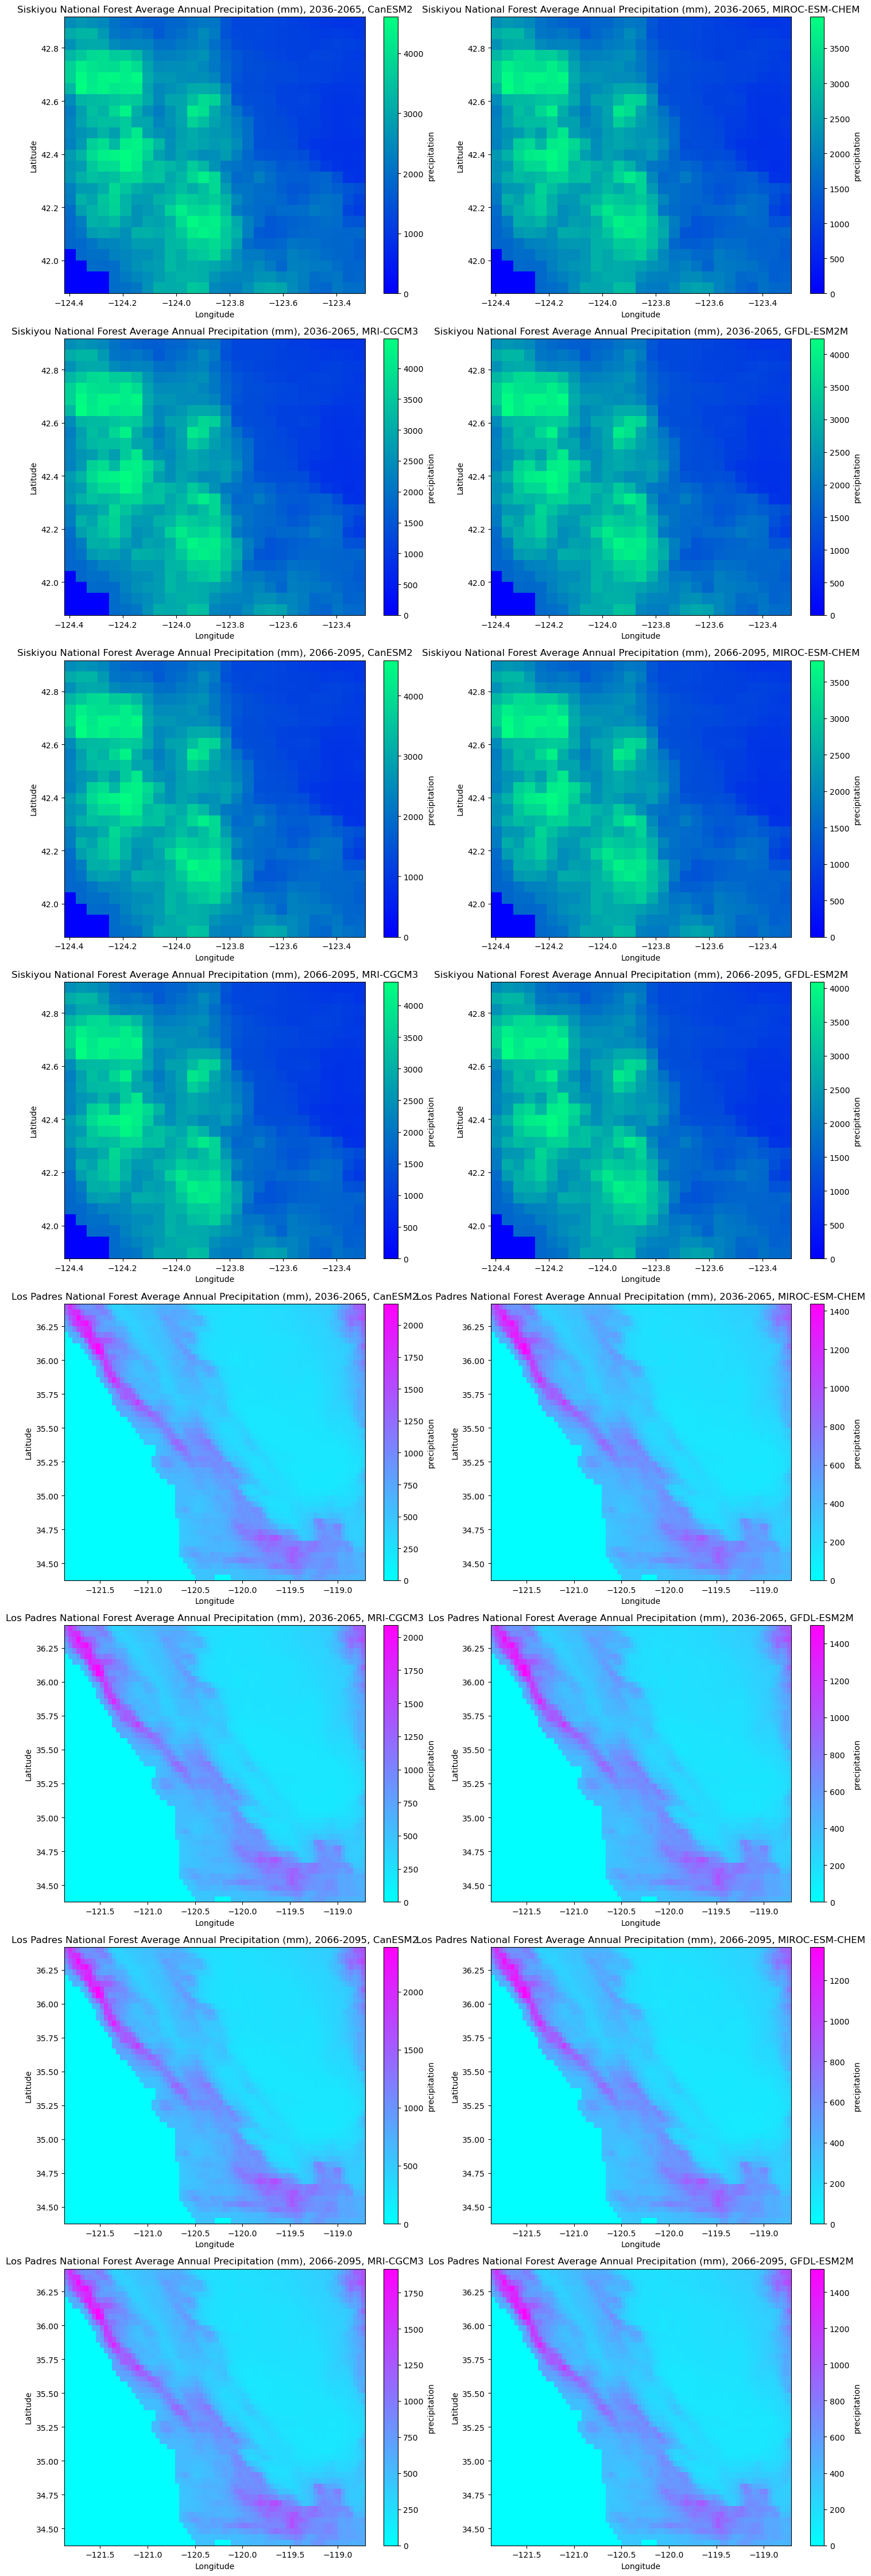

In [ ]:
# Create grid for the subplots
# [row, column]
fig, axs = plt.subplots(8, 2, figsize=(15, 45))

# Plot ave_annual_pr_das_list[0]
pc1 = ave_annual_pr_das_list[0].plot(ax=axs[0, 0], cmap="winter")
axs[0, 0].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2036-2065, CanESM2")
axs[0, 0].set_xlabel("Longitude")
axs[0, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[1]
pc2 = ave_annual_pr_das_list[1].plot(ax=axs[0, 1], cmap="winter")
axs[0, 1].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2036-2065, MIROC-ESM-CHEM")
axs[0, 1].set_xlabel("Longitude")
axs[0, 1].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[2]
pc3 = ave_annual_pr_das_list[2].plot(ax=axs[1, 0], cmap="winter")
axs[1, 0].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2036-2065, MRI-CGCM3")
axs[1, 0].set_xlabel("Longitude")
axs[1, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[3]
pc4 = ave_annual_pr_das_list[3].plot(ax=axs[1, 1], cmap="winter")
axs[1, 1].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2036-2065, GFDL-ESM2M")
axs[1, 1].set_xlabel("Longitude")
axs[1, 1].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[4]
pc4 = ave_annual_pr_das_list[4].plot(ax=axs[2, 0], cmap="winter")
axs[2, 0].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2066-2095, CanESM2")
axs[2, 0].set_xlabel("Longitude")
axs[2, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[5]
pc4 = ave_annual_pr_das_list[5].plot(ax=axs[2, 1], cmap="winter")
axs[2, 1].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2066-2095, MIROC-ESM-CHEM")
axs[2, 1].set_xlabel("Longitude")
axs[2, 1].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[6]
pc4 = ave_annual_pr_das_list[6].plot(ax=axs[3, 0], cmap="winter")
axs[3, 0].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2066-2095, MRI-CGCM3")
axs[3, 0].set_xlabel("Longitude")
axs[3, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[7]
pc4 = ave_annual_pr_das_list[7].plot(ax=axs[3, 1], cmap="winter")
axs[3, 1].set_title("Siskiyou National Forest Average Annual Precipitation (mm), 2066-2095, GFDL-ESM2M")
axs[3, 1].set_xlabel("Longitude")
axs[3, 1].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[8]
pc4 = ave_annual_pr_das_list[8].plot(ax=axs[4, 0], cmap="cool")
axs[4, 0].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2036-2065, CanESM2")
axs[4, 0].set_xlabel("Longitude")
axs[4, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[9]
pc4 = ave_annual_pr_das_list[9].plot(ax=axs[4, 1], cmap="cool")
axs[4, 1].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2036-2065, MIROC-ESM-CHEM")
axs[4, 1].set_xlabel("Longitude")
axs[4, 1].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[10]
pc4 = ave_annual_pr_das_list[10].plot(ax=axs[5, 0], cmap="cool")
axs[5, 0].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2036-2065, MRI-CGCM3")
axs[5, 0].set_xlabel("Longitude")
axs[5, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[11]
pc4 = ave_annual_pr_das_list[11].plot(ax=axs[5, 1], cmap="cool")
axs[5, 1].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2036-2065, GFDL-ESM2M")
axs[5, 1].set_xlabel("Longitude")
axs[5, 1].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[12]
pc4 = ave_annual_pr_das_list[12].plot(ax=axs[6, 0], cmap="cool")
axs[6, 0].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2066-2095, CanESM2")
axs[6, 0].set_xlabel("Longitude")
axs[6, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[13]
pc4 = ave_annual_pr_das_list[13].plot(ax=axs[6, 1], cmap="cool")
axs[6, 1].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2066-2095, MIROC-ESM-CHEM")
axs[6, 1].set_xlabel("Longitude")
axs[6, 1].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[14]
pc4 = ave_annual_pr_das_list[14].plot(ax=axs[7, 0], cmap="cool")
axs[7, 0].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2066-2095, MRI-CGCM3")
axs[7, 0].set_xlabel("Longitude")
axs[7, 0].set_ylabel("Latitude")

# Plot ave_annual_pr_das_list[15]
pc4 = ave_annual_pr_das_list[15].plot(ax=axs[7, 1], cmap="cool")
axs[7, 1].set_title("Los Padres National Forest Average Annual Precipitation (mm), 2066-2095, GFDL-ESM2M")
axs[7, 1].set_xlabel("Longitude")
axs[7, 1].set_ylabel("Latitude")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# add specific names to the dataarrays in the ave_annual_pr_das_list
ave_annual_pr_das_list[0].name = (
    'Siskiyou Average Annual Precipitation (mm), 2036-2065, CanESM2')
ave_annual_pr_das_list[1].name = (
    'SiskiyouvAverage Annual Precipitation (mm), 2036-2065, MIROC-ESM-CHEM')
ave_annual_pr_das_list[2].name = (
    'Siskiyou Average Annual Precipitation (mm), 2036-2065, MRI-CGCM3')
ave_annual_pr_das_list[3].name = (
    'Siskiyou Average Annual Precipitation (mm), 2036-2065, GFDL-ESM2M')
ave_annual_pr_das_list[4].name = (
    'Siskiyou Average Annual Precipitation (mm), 2066-2095, CanESM2')
ave_annual_pr_das_list[5].name = (
    'Siskiyou Average Annual Precipitation (mm), 2066-2095, MIROC-ESM-CHEM')
ave_annual_pr_das_list[6].name = (
    'Siskiyou Average Annual Precipitation (mm), 2066-2095, MRI-CGCM3')
ave_annual_pr_das_list[7].name = (
    'Siskiyou Average Annual Precipitation (mm), 2066-2095, GFDL-ESM2M')
ave_annual_pr_das_list[8].name = (
    'Los Padres Average Annual Precipitation (mm), 2036-2065, CanESM2')
ave_annual_pr_das_list[9].name = (
    'Los Padres Average Annual Precipitation (mm), 2036-2065, MIROC-ESM-CHEM')
ave_annual_pr_das_list[10].name = (
    'Los Padres Average Annual Precipitation (mm), 2036-2065, MRI-CGCM3')
ave_annual_pr_das_list[11].name = (
    'Los Padres Average Annual Precipitation (mm), 2036-2065, GFDL-ESM2M')
ave_annual_pr_das_list[12].name = (
    'Los Padres Average Annual Precipitation (mm), 2066-2095, CanESM2')
ave_annual_pr_das_list[13].name = (
    'Los Padres Average Annual Precipitation (mm), 2066-2095, MIROC-ESM-CHEM')
ave_annual_pr_das_list[14].name = (
    'Los Padres Average Annual Precipitation (mm), 2066-2095, MRI-CGCM3')
ave_annual_pr_das_list[15].name = (
    'Los Padres Average Annual Precipitation (mm), 2066-2095, GFDL-ESM2M')

In [25]:
%store ave_annual_pr_das_list climate_df_list

Stored 'ave_annual_pr_das_list' (list)
Stored 'climate_df_list' (list)
